# Dependency Graph Investigation

With this notebook, we're aiming to take some pre-processed data, namely a directed graph with some associated info:
- labeled/indexed by **node name**
- associated with a **node class**
- a **probability of being a cache hit**
- an **execution duration**

With that, we want to answer a few questions:
- within the graph, which nodes create "bottlenecks"
  - we're still trying to figure out what the best definition for that is:
    - ancestors * descendants
    - highest in_degree, or out_degree
    - expected duration is high, but not just high: it's higher than the expected duration for all descendants; is that essentially in-degree
- among nodes with duration, which ones are the most likely to get invalidated and take a significant amount of time
- among nodes which can change (source files), which ones affect the greatest sum of duration and what's the expected value, given its likelihood to change

There are several ideas to pursue when deciding on which metrics to rank with, such as:
- do we always want to use actual data for durations and probabilities? maybe we'd have a better idea of the structure / properly weight some of the "build" steps by assuming a more uniform duration and probability (that's roughly what we'd do by using a count of source ancestors / descendants)

## TODOS

- [ ] Can we get the bokeh panels here for better display of subgraphs?

## Data Collection

Let's gather our input data

In [1]:
import math

import networkx
import pandas
from networkx.drawing import nx_agraph

In [2]:
%matplotlib inline

In [3]:
g = networkx.read_gml("/home/mchristen/tmp/drake/my.gml")

In [4]:
nodes = g.nodes(data=True)

In [5]:
df_nodes = pandas.DataFrame(
    [n[1] for n in nodes],
    columns=[
        "node_name",
        "node_class",
        "node_duration_s",
        "node_probability_cache_hit",
    ],
)
# df_nodes = pandas.DataFrame([n[1] for n in nodes], columns=['node_name', 'node_class', 'num_parents', 'num_ancestors', 'num_duration_ancestors', 'num_children', 'num_descendants', 'num_source_descendants', 'pagerank', 'hubs_metric', 'authorities_metric', 'node_duration_s', 'group_duration_s', 'expected_duration_s', 'node_probability_cache_hit', 'group_probability_cache_hit'])
df_nodes.set_index("node_name", inplace=True)

In [6]:
df_nodes

,node_class,node_duration_s,node_probability_cache_hit
node_name,,,
//:all_models,filegroup,0.0,1.0
//bindings/pydrake/multibody:models,filegroup,0.0,1.0
//examples/acrobot:models,filegroup,0.0,1.0
//examples/hardware_sim:demo_data,filegroup,0.0,1.0
//examples/hydroelastic/ball_plate:models,filegroup,0.0,1.0
...,...,...,...
//visualization:visualization_config_functions_test.stripped,unknown,0.0,1.0
//visualization:visualization_config_functions_test.dwp,unknown,0.0,1.0
//visualization:visualization_config_functions_test_clang_format_lint,_redirect_test,0.0,1.0


## Data Analysis

Now, we want to get a better understanding of the "shape" of our data in order to refine the initial data we have. We'll want to do a few things.
- get a better idea for the nodes we have
  - how do the node_classes break down
  - which nodes may we want to exclude from this data set
- use that information to refine the graph and the associated table
- define sets of nodes
  - what has duration
  - what has the possibility of changing
  - what is a possible "bottleneck"

All of this may be informed by the type of analysis we're doing, eg) if we're just looking at C++ code, we may refine our nodes to `cc_*` classes, or `py_*` for python. Though, ideally we won't have to do that sort of selection up front as the groups will be fairly disjoint at most times.

In [7]:
# df_nodes.groupby("node_class").describe()['num_duration_ancestors']['mean'].sort_values(ascending=False)[:40].plot.bar()

From the above query, we can see a few things:
- We have A LOT of `py_test` invocations (7,239)
- What the heck is a `_redirect_test`?
  - Looks like that's mostly lint for us
- We've got about 4,824 source files
- There are a large portion of "unknown" objects
- After that, we've got a majority of `cc_library` objects (10%) so we've probably got a predominately C++ repo, with some py_test tooling

In [8]:
# XXX: This should be empty at start, and likely revisited / refined as we go
# XXX: Could likely refine this a lot easier with tag filtering in the initial bazel query
refined_df_nodes = df_nodes.loc[
    ~(
        (df_nodes["node_class"] == "unknown")
        & (
            (df_nodes.index.str.endswith(".stripped"))
            | (df_nodes.index.str.endswith(".dwp"))
            | (df_nodes.index.str.endswith(".java"))
            | (df_nodes.index.str.endswith(".jar"))
            | df_nodes.index.str.endswith(".pyi")
        )
    )
    & ~(
        (df_nodes["node_class"] == "_redirect_test")
        & ~(df_nodes.index.str.endswith("_test"))
    )
    & ~(
        (df_nodes["node_class"] == "py_test")
        & ~(df_nodes.index.str.endswith("_test"))
    )
    & ~((df_nodes["node_class"] == "genquery"))
]
refined_df_nodes

,node_class,node_duration_s,node_probability_cache_hit
node_name,,,
//:all_models,filegroup,0.000,1.0
//bindings/pydrake/multibody:models,filegroup,0.000,1.0
//examples/acrobot:models,filegroup,0.000,1.0
//examples/hardware_sim:demo_data,filegroup,0.000,1.0
//examples/hydroelastic/ball_plate:models,filegroup,0.000,1.0
...,...,...,...
//visualization:BUILD.bazel,source_file,0.000,1.0
//visualization:visualization_config.cc,source_file,0.000,1.0
//visualization:visualization_config.h,source_file,0.000,1.0


In [9]:
df_nodes = refined_df_nodes

In [10]:
# Short description of total number of nodes and our node_classes
# Had 25,836 nodes, now 9,630
print(f"Nodes: {len(df_nodes)}")
print(f"We have {df_nodes['node_class'].nunique()} node classes")

Nodes: 9630
We have 44 node classes


In [11]:
# Quantity
count_df = (
    df_nodes.groupby("node_class")["node_class"]
    .count()
    .sort_values(ascending=False)
    .to_frame()
)
count_df["pct"] = count_df["node_class"] * 100 / len(df_nodes)
count_df

,node_class,pct
node_class,,
source_file,4824,50.093458
cc_library,1274,13.229491
cc_test,994,10.321911
drake_installed_headers,977,10.145379
py_test,247,2.564901
_redirect_test,227,2.357217
unknown,168,1.744548
cc_binary,144,1.495327
py_library,133,1.381101


<Axes: xlabel='node_class'>

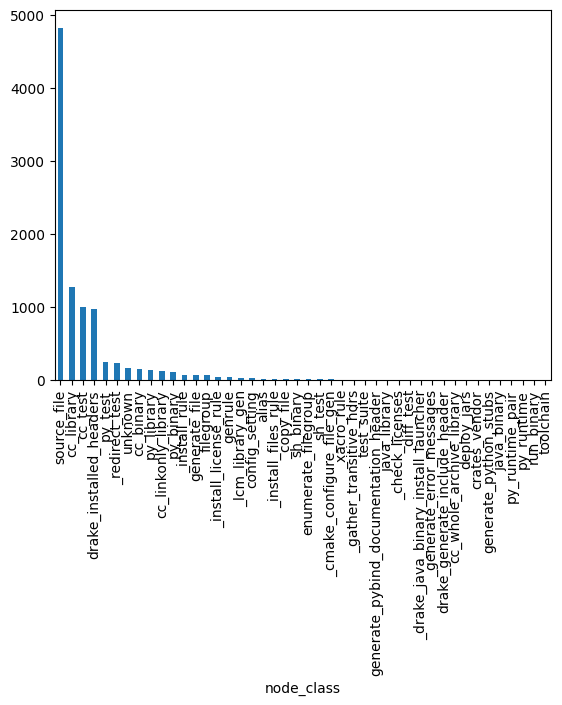

In [12]:
count_df["node_class"].plot.bar()

<Axes: ylabel='node_class'>

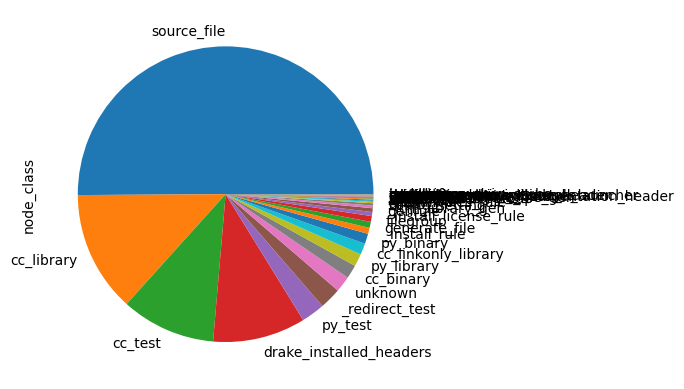

In [13]:
count_df["node_class"].plot.pie()

In [14]:
# So, let's take a look at some of these and figure out how to refine them a bit


# XXX: Just use .index.tolist()
def show_indices(df: pandas.DataFrame, node_class: str) -> None:
    for k in df.loc[df["node_class"] == node_class].index:
        print(k)


# Omitted for brevity, but looks like that's mostly lint, let's remove
# for k in df_nodes.loc[df_nodes['node_class'] == '_redirect_test'].index:
#     print(k)

# for k in df_nodes.loc[df_nodes['node_class'] == '_redirect_test'].index:
#     # if k.endswith('lint') or k.endswith('codestyle') or k.endswith('_buildifier'):
#     #     continue
#     if k.endswith('_test'):
#         print(k)

In [15]:
# Start with 6,815
# Refine to 227
# XXX: More useful later if we use inverse
len(
    df_nodes.loc[
        (df_nodes["node_class"] == "_redirect_test")
        & (df_nodes.index.str.endswith("_test"))
    ]
)

227

In [16]:
# Let's take a look at py_test
# Another abundance of lint, codestyle
# show_indices(df_nodes, 'py_test')
# 7,239 to 247
# XXX: Should check if this overlaps with _redirect_test at all ...
len(
    df_nodes.loc[
        (df_nodes["node_class"] == "py_test")
        & (df_nodes.index.str.endswith("_test"))
    ]
)

247

In [17]:
# Now let's take a look at the "unknown"
# show_indices(df_nodes, 'unknown')
# Seems to mostly be .stripped, .dwp, .jar, .pyi
# 2,538 to 168
df_nodes.loc[
    (df_nodes["node_class"] == "unknown")
    & ~(df_nodes.index.str.endswith(".stripped"))
    & ~(df_nodes.index.str.endswith(".dwp"))
    & ~(df_nodes.index.str.endswith(".java"))
    & ~(df_nodes.index.str.endswith(".jar"))
    & ~(df_nodes.index.str.endswith(".pyi"))
]

,node_class,node_duration_s,node_probability_cache_hit
node_name,,,
//:install_test_commands,unknown,0.0,1.0
//:install_test.py,unknown,0.0,1.0
//bindings/pydrake:documentation_pybind.h,unknown,0.0,1.0
//bindings/pydrake:pydrake/py.typed,unknown,0.0,1.0
//bindings/pydrake/common:test/deprecation_example/example_class_documentation.h,unknown,0.0,1.0
...,...,...,...
//tools/workspace/lcm/example:package1/package2/lcmt_foo.py,unknown,0.0,1.0
//tools/workspace/nlopt_internal:test/nlopt-upstream.hpp,unknown,0.0,1.0
//tools/workspace/openusd_internal:gen/files.bzl,unknown,0.0,1.0


In [18]:
# cc_library seems mostly legit
# df_nodes.loc[(df_nodes['node_class'] == 'cc_library')].index.tolist()

In [19]:
# drake_installed_headers: seems fine
# df_nodes.loc[(df_nodes['node_class'] == 'drake_installed_headers')].index.tolist()
# and genquery, it's all lint, let's remove
# df_nodes.loc[(df_nodes['node_class'] == 'genquery')].index.tolist()

## Data definition

Now that we have a smaller set, let's refine our information and derive the values we want

In [21]:
g = g.subgraph(df_nodes.index.tolist())

In [22]:
node_durations = {}
for node, duration in df_nodes["node_duration_s"].items():
    node_durations[node] = duration

In [23]:
node_probabilities = {}
for node, probability in df_nodes["node_probability_cache_hit"].items():
    node_probabilities[node] = probability

In [58]:
def get_subgraph(label: str, graph: networkx.DiGraph) -> networkx.DiGraph:
    return graph.subgraph(
        networkx.ancestors(graph, label)
        | networkx.descendants(g, label)
        | set([label])
    )

In [59]:
def show_graph(
    graph: networkx.DiGraph, include_labels: bool = True, lr: bool = False
) -> None:
    if include_labels:
        a = nx_agraph.to_agraph(graph)
        # args="-Grankdir=LR")
        if lr:
            a.layout("dot", args="-Grankdir=LR")
        else:
            a.layout("dot")
        display(a)
    else:
        networkx.draw(graph, nx_agraph.graphviz_layout(graph, prog="dot"))

In [61]:
# Example investigation for a particular label:


def investigate_label(g: networkx.DiGraph, label: str) -> None:
    print(g.in_degree(label))
    print(list(g.predecessors(label)))
    print(g.out_degree(label))
    print(list(g.successors(label)))
    ancestors = networkx.ancestors(g, label)
    descendants = networkx.descendants(g, label)
    print(len(ancestors))
    # print(ancestors)
    print(len(descendants))
    # print(descendants)
    # show_graph(get_subgraph(label, g))


investigate_label(g, label="//visualization:visualization_config.h")

2
['//visualization:visualization_config', '//visualization:visualization_config.installed_headers']
0
[]
559
0


In [56]:
# Taking 7.43s for 25,836 nodes: seems like way too long
# Can do it in about 2.34s with direct dictionary access
# %timeit df_nodes['computed_duration_s'] = [df_nodes.loc[node]['node_duration_s'] + df_nodes.loc[list(networkx.ancestors(g, node))]['node_duration_s'].sum() for node in df_nodes.index]
# assert len(df_nodes.loc[abs(df_nodes['computed_duration_s'] - df_nodes['group_duration_s']) > 0.01]) == 0
# df_nodes['computed_duration_s'] = [node_durations[node] + sum([node_durations[ancestor] for ancestor in networkx.ancestors(g, node)]) for node in df_nodes.index]
# assert len(df_nodes.loc[abs(df_nodes['computed_duration_2_s'] - df_nodes['group_duration_s']) > 0.01]) == 0
# %timeit df_nodes['computed_probability_cache_hit'] = [node_probabilities[node] * math.prod([node_probabilities[descendant] for descendant in networkx.descendants(g, node)]) for node in df_nodes.index]
# assert len(df_nodes.loc[abs(df_nodes['computed_probability_cache_hit'] - df_nodes['group_probability_cache_hit']) > 0.0001]) == 0

In [74]:
duration_node_set = set(
    [node for node, dur in node_durations.items() if dur > 0]
)
source_node_set = set(
    df_nodes.loc[df_nodes["node_class"] == "source_file"].index
)

In [68]:
num_duration_ancestors = []
computed_duration_s = []
for node in df_nodes.index:
    ancestors = networkx.ancestors(g, node)
    computed_duration_s.append(
        node_durations[node]
        + sum([node_durations[ancestor] for ancestor in ancestors])
    )
    num_duration_ancestors.append(len(duration_node_set & ancestors))

In [69]:
df_nodes.loc[:, "computed_num_duration_ancestors"] = num_duration_ancestors
df_nodes.loc[:, "computed_duration_s"] = computed_duration_s

In [76]:
num_source_file_descendants = []
computed_probability_cache_hit = []
for node in df_nodes.index:
    descendants = networkx.descendants(g, node)
    computed_probability_cache_hit.append(
        node_probabilities[node]
        * math.prod(
            [node_probabilities[descendant] for descendant in descendants]
        )
    )
    num_source_file_descendants.append(len(source_node_set & descendants))

In [79]:
df_nodes.loc[:, "computed_num_source_file_descendants"] = (
    num_source_file_descendants
)
df_nodes.loc[:, "computed_probability_cache_hit"] = (
    computed_probability_cache_hit
)

610.509291


node_name
//geometry/benchmarking:mesh_intersection_benchmark_test             45.469
//:py/install_test                                                   40.974
//tutorials:py/hydroelastic_contact_basics_test                      21.465
//solvers/benchmarking:benchmark_ipopt_solver_test                   21.405
//geometry/render_gltf_client:py/integration_test                    17.899
                                                                      ...  
//geometry/proximity:make_ellipsoid_mesh                              0.000
//geometry/proximity:make_sphere_field                                0.000
//geometry/benchmarking:iris_in_configuration_space_benchmarks        0.000
//geometry/benchmarking:iris_in_configuration_space_benchmarks.cc     0.000
//geometry/benchmarking:boxes_overlap_experiment                      0.000
Name: node_duration_s, Length: 9630, dtype: float64

<Axes: ylabel='Frequency'>

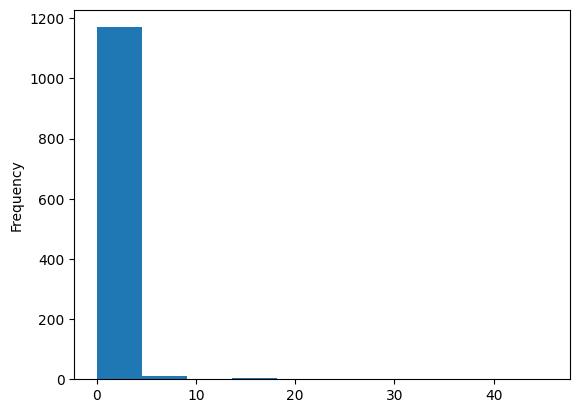

In [98]:
print(df_nodes["node_duration_s"].sum())
display(
    df_nodes.sort_values("node_duration_s", ascending=False)["node_duration_s"]
)
df_nodes.loc[df_nodes["node_duration_s"] > 0]["node_duration_s"].plot.hist()

node_class                               cc_test
node_duration_s                           45.469
node_probability_cache_hit                   1.0
computed_duration_s                       45.469
computed_num_duration_ancestors                0
computed_probability_cache_hit          0.879063
x                                          421.0
computed_num_source_file_descendants         258
Name: //geometry/benchmarking:mesh_intersection_benchmark_test, dtype: object

0
[]
8
['//common:essential', '//geometry/benchmarking:mesh_intersection_benchmark.cc', '//geometry/proximity:make_ellipsoid_field', '//geometry/proximity:make_ellipsoid_mesh', '//geometry/proximity:make_sphere_mesh', '//geometry/proximity:mesh_intersection', '//math:math', '//tools:drake_werror']
0
421


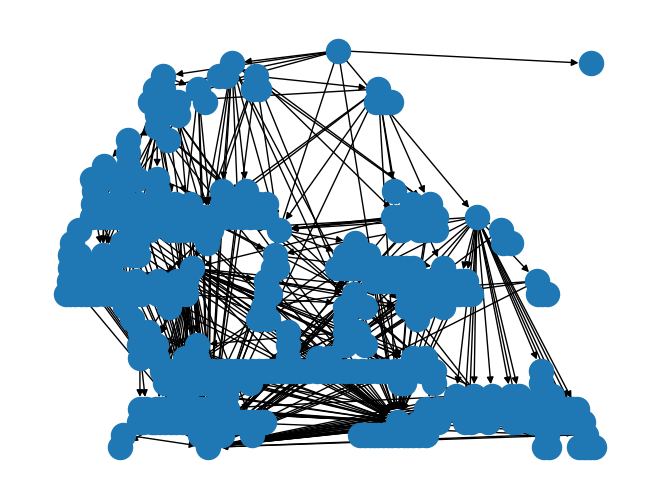

In [106]:
display(
    df_nodes.loc["//geometry/benchmarking:mesh_intersection_benchmark_test"]
)
investigate_label(
    g, "//geometry/benchmarking:mesh_intersection_benchmark_test"
)
show_graph(
    get_subgraph(
        "//geometry/benchmarking:mesh_intersection_benchmark_test", g
    ),
    include_labels=False,
)

In [115]:
# Disconnected graphs may show that we over-refined or that we can trim further
disconnected_graphs = list(networkx.weakly_connected_components(g))
print(len(disconnected_graphs))
for sub in disconnected_graphs:
    if len(sub) < 50:
        print(sub)

825
{'//bindings/pydrake/multibody:meshcat_test'}
{'//examples/multibody/strandbeest:BUILD.bazel'}
{'//tools/workspace/tinyobjloader_internal:package.BUILD.bazel'}
{'//tools/workspace/csdp_internal:repository.bzl'}
{'//tools/dynamic_analysis:lsan.supp', '//tools/dynamic_analysis:lsan', '//tools/dynamic_analysis:lsan.sh'}
{'//tools/workspace:default.bzl'}
{'//tools/workspace/opencl:repository.bzl'}
{'//tools/workspace/statsjs:repository.bzl'}
{'//tools/workspace/sdformat_internal:package.BUILD.bazel'}
{'//tools/workspace/crate_universe/lock/details:BUILD.ident_case-1.0.1.bazel', '//tools/workspace/crate_universe/lock/details:BUILD.cfg-if-1.0.0.bazel', '//tools/workspace/crate_universe/lock/details:BUILD.lapack-0.19.0.bazel', '//tools/workspace/crate_universe/lock/details:BUILD.blas-0.22.0.bazel', '//tools/workspace/crate_universe/lock/details:BUILD.num-traits-0.2.19.bazel', '//tools/workspace/crate_universe/lock/details:BUILD.syn-2.0.90.bazel', '//tools/workspace/crate_universe/lock/det

## Thoughts

Chatting w/ Ben:
- 3 questions to answer
  1. What are the bottlenecks in the graph, highest expected_duration_s; how does this compare to in-edges?
  2. What are the most expensive source files, highest group_duration_s or expected_duration_s or num_duration_ancestors (uniform)
  3. What are the most expensive tests, highest expected_duration_s
- The middle bottlenecks should be higher than the source files and tests since it's in the middle; has the same group_duration, but more nodes
- Well, not quite, imagine it reconvenes to a higher node, that would also show this
- Should we identify things that depend on a lot, not just things that are heavily depended upon?

In [ ]:
# 5 nodes that take time, sorted by largest number of source_descendants
# XXX: How to select based on this weighted by node_duration_s
df_nodes.loc[df_nodes["node_duration_s"] > 0].sort_values(
    ["num_source_descendants", "node_duration_s"], ascending=False
)[:5]

In [ ]:
df_nodes["weighted_source"] = (
    df_nodes["node_duration_s"] * df_nodes["num_source_descendants"]
)

In [ ]:
# Find the most impacted tests
df_nodes.nlargest(10, "weighted_source")

In [ ]:
df_nodes.loc[
    (df_nodes["weighted_source"] < 5_000) & (df_nodes["weighted_source"] > 200)
]["weighted_source"].plot.hist()

In [ ]:
# Find the most impacting source files
df_nodes.loc[df_nodes["node_probability_cache_hit"] < 1].nlargest(
    10, "num_duration_ancestors"
)

In [ ]:
len(networkx.ancestors(g, "//math:matrix_util.h"))

In [ ]:
df_nodes["num_parents"].plot.hist()

In [ ]:
H = get_subgraph("//math:matrix_util.h", g)

In [ ]:
# show_graph(H, include_labels=False)

In [ ]:
# show_graph(H, include_labels=True)

In [ ]:
df_nodes["num_parents"].mean()

In [ ]:
df_nodes.groupby("node_class").count().sort_values(
    "num_descendants", ascending=False
)

In [ ]:
df_nodes.groupby("node_class").describe()["num_ancestors"].sort_values(
    ["max", "75%"], ascending=False
)[:10]

In [ ]:
df_nodes.groupby("node_class").describe()["num_duration_ancestors"][
    "mean"
].sort_values(ascending=False)[:40].plot.bar()

In [ ]:
df_nodes.groupby("node_class").describe()["num_source_descendants"][
    "mean"
].sort_values(ascending=False)[:40].plot.bar()

In [ ]:
df_nodes.loc[df_nodes["node_class"].str.endswith("_test")].sort_values(
    "num_source_descendants", ascending=False
)["num_source_descendants"].plot.bar(subplots=True)

In [ ]:
df_nodes.loc[df_nodes["node_class"].str.endswith("_test")].sort_values(
    "group_probability_cache_hit", ascending=True
)["group_probability_cache_hit"].plot.bar(subplots=True)

In [ ]:
df_nodes.loc[df_nodes["node_class"] == "source_file"]

In [ ]:
df_nodes.loc[df_nodes["node_class"] == "source_file"].nlargest(
    100, "group_duration_s"
)

In [ ]:
(
    df_nodes.loc[
        (df_nodes["node_class"] == "py_test")
        & ~(df_nodes.index.str.endswith("lint"))
        & ~(df_nodes.index.str.endswith("style"))
        & ~(df_nodes.index.str.endswith("buildifier"))
        # & (df_nodes['num_source_descendants'] < 1_750)
    ].sort_values("num_source_descendants", ascending=False)[
        "num_source_descendants"
    ]
    # .plot.hist()
).plot.hist()

In [ ]:
show_graph(get_subgraph("//tools:__init__.py", g))